# Micromagnetics basics with J-OOMMF

In this tutorial, we introduce basic concepts of computational micromagnetics using Python interface for OOMMF in Jupyter notebook (J-OOMMF).

## Magnetic energies

The basic building block of any magnetic system is the magnetic moment. Magnetic moments interact eithir with its immediate environment of with each other. Now, we introduce some basic magnetic interactions that we are going to use later to define Hamiltonians of micromagnetic systems.

### Initial definitions

Before we start running OOMMF simulations with basic interactions, we need to define several micromagnetic objects that we are going to use later.

First of all, we need to import necessary Python packages. They are `oommfc` which we use to run OOMMF simulations and `discretisedfield` to define finite difference fields. In the following cell we import those packages and we also run `%matplotlib inline` command to allow plotting in the notebook.

In [1]:
%matplotlib inline
import oommfc as oc
import discretisedfield as df

/Users/fangohr/anaconda3/envs/joommf/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In the next step, we have to define the mesh on which the finite difference field will be defined. For a mesh, we choose a one-dimensional system with dimensions:

- length $L = 100 \,\text{nm}$,
- width and height $d = 10 \,\text{nm}$.

Therefore, we can say that our mesh spans between points $p_{1} = (0, 0, 0)$ and $p_{2} = (100 \,\text{nm}, 10 \,\text{nm}, 10 \,\text{nm})$. This one-dimensional sample we discretise in cells of size $(10 \,\text{nm}, 10 \,\text{nm}, 10 \,\text{nm})$ defined using `cell` parameter. In other words, we discretise our one-dimensional sample into 10 cells.

The mesh object is created as:

In [2]:
p1 = (0, 0, 0)
p2 = (100e-9, 10e-9, 10e-9)
cell=(10e-9, 10e-9, 10e-9)

mesh = oc.Mesh(p1=p1, p2=p2, cell=cell)

We can check the number of discretisation cells in all three directions are as expected $(10, 1, 1)$.

In [3]:
mesh.n

(10, 1, 1)

Also, in order to check that parameters $p_{1}$ and $p_{2}$ resulted in the required mesh dimensions, we ask for the `mesh.l` property. Please note that all dimensions are given in meters:

In [4]:
mesh.l

(1e-07, 1e-08, 1e-08)

### Initial magnetisation

Micromagnetic problem can also be understood ad an initial value problem that evolves over time. Initial value is the initial magnetisation configuration which is of great importance in micromagnetics.

In this tutorial, we are going to always use a random magnetisation configuration as an initial state. In J-OOMMF, the system's state is always a finite difference field, that we create using the classes provided in `discretisedfield` package. To define a finite difference field, we need to use `discretisedfield.Field` class to which we need to provide:

- mesh (we created in the previous step),
- value (needs to be a random value), and
- norm (magnetisation  saturation).

A random magnetisation configuration can be defined by passing a Python fuction which generates a random tuple of length 3 for any position in the mesh. This Python function is:

In [5]:
import random

def random_m(pos):
    return tuple(2*random.random()-1 for i in range(3))

Now, if we say that our magnetisation saturation $M_\text{s} = 8 \times 10^{6} \,\text{A}\,\text{m}^{-1}$, a random field we create with the following line:

In [6]:
Ms = 8e6  # magnetisation saturation (A/m)

random_field = df.Field(mesh, value=random_m, norm=Ms)

We can check the average vaule of this field (in units of A/m) as:

In [7]:
random_field.average

(-1558834.5537459408, 1431833.9247788684, -956493.63114790688)

Or plot the magnetisation configuration:

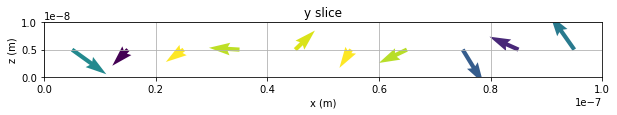

In [8]:
random_field.plot_slice("y", 0);

### Dynamics

In the rest of this tutorial, we will run the magnetisation evolution governed with the Landau-Lifshitz-Gilbert equation:

$$\frac{d\mathbf{m}}{dt} = \underbrace{-\gamma_{0}(\mathbf{m} \times \mathbf{H}_\text{eff})}_\text{precession} + \underbrace{\alpha\left(\mathbf{m} \times \frac{d\mathbf{m}}{dt}\right)}_\text{damping}$$

where $\gamma_{0} = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$ and $\alpha$ is the Gilbert damping. Defining dynamics will be described in more details in another tutorial, but for now we can define it as:

In [9]:
gamma = 2.211e5  # gyrotropic ration
alpha = 0.5  # Gilbert damping

dynamics = oc.Precession(gamma=gamma) + oc.Damping(alpha=alpha)

We can check the dynamics

In [10]:
dynamics

Precession(gamma=221100.0) + Damping(alpha=0.5)

We see 10 magnetisation field points defined at the centre of each finite difference cell point in the random directions.

### Zeeman energy

Probably the simplest magnetic energy is the Zeeman interaction. This energy tends to align all magnetic moments in the magnetic system parallel to the applied magnetic field $\mathbf{H}$. Knowing the magnetisation configuration $\mathbf{m}$ and applied magnetic field $\mathbf{H}$, the Zeeman energy density can be computed as

$$w_\text{z} = - \mu_{0}M_\text{s} \mathbf{m} \cdot \mathbf{H},$$

where $M_\text{s}$ is the saturation magnetisation and $\mu_{0} = 4\pi \times 10^{-7} \,\text{N}\,\text{A}^{-2}$. We can see that this energy is minimal when $\mathbf{m}$ and $\mathbf{H}$ are parallel to each other - magnetisation is aligned with external magnetic field.

If we assume our magentic field is applied in the $z$ diirection with $5 \times 10^{6} \,\text{A}\,\text{m}^{-1}$, the Zeeman energy object is created as:

In [11]:
H = (0, 0, 5e6)  # external magnetic field (A/m)

zeeman = oc.Zeeman(H=H)

We can look at the energy density expression

In [12]:
zeeman

Zeeman(H=(0, 0, 5000000.0))

and check whether the external field value $\mathbf{H}$ is as expected:

In [13]:
zeeman.H

(0, 0, 5000000.0)

After we created the Zeeman energy object, we can simulate the magnetisation evolution. Before we run the simulation, we need to define the `system` object and provide it with a name.

In [14]:
system = oc.System(name="zeeman_tutorial")

Now, it is necessary to define its Hamiltonian by providing it with only one term - the Zeeman term we just created.

In [15]:
system.hamiltonian = zeeman

After running this cell, the system's Hamiltonian is:

In [16]:
system.hamiltonian

Zeeman(H=(0, 0, 5000000.0))

The dynamics and initial magnetisation we define with previously defined `random_field` and `dynamics` object.

In [17]:
system.dynamics = dynamics
system.m = random_field

At this point, our micromagnetic system is fully defined. We run its evolution using `TimeDriver`:

In [18]:
td = oc.TimeDriver()

td.drive(system, t=0.5e-9, n=100)

2017/3/19 1:2: Calling OOMMF (zeeman_tutorial/zeeman_tutorial.mif) ... [1.5s]


The resulting magnetisation configuration is:

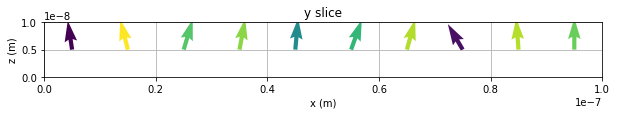

In [19]:
system.m.plot_slice("y", 0);

By looking at the magnetisation configuration we can conclude that Zeeman energy aligned all magnetic moments in the $z$ direction - in the direction of applied magnetic field. We can also check this by asking for the average magnetisation:

In [20]:
system.m.average

(187927.55128197995, -103960.56639038122, 7578625.8955728533)

We see that $m_{z} \approx M_\text{s}$, while $m_{x} \approx 0$ and $m_{y} \approx 0$.

### Uniaxial anisotropy

Similar to the Zeeman energy, uniaxial anisotropy energy is also local. Its energy density is defined as:

$$w_\text{a} = K(\mathbf{m} \cdot \hat{\mathbf{u}})^{2},$$

where $K$ is the anisotropy coefficient and $\hat{\mathbf{u}}$ is the anisotropy axis. By looking at the energy density equation we can see that it is minimal when magnetisation $\mathbf{m}$ is either parallel or antiparallel to the uniaxial anisotropy axis $\hat{\mathbf{u}}$. If we assume the uniaxial anisotropy axis is in the $z$ direction and anisotropy coefficient is $K = 8 \times 10^{5} \,\text{J}\,\text{m}^{-3}$, the uniaxial anistropy energy object can be created as:

In [21]:
K = 8e5  # anisotropy coefficient (J/m**3)
u = (0, 0, 1)

uniaxial_anisotropy = oc.UniaxialAnisotropy(K=K, u=u)

Now, same as in the case of Zeeman energy, we define the system and run it time evolution.

In [22]:
system = oc.System(name="uniaxial_anisotropy_tutorial")

system.hamiltonian = uniaxial_anisotropy
system.dynamics = dynamics
system.m = random_field

system.hamiltonian

UniaxialAnisotropy(K=800000.0, u=(0, 0, 1))

In [23]:
td = oc.TimeDriver()
td.drive(system, t=1e-9, n=100)

2017/3/16 12:18: Calling OOMMF (uniaxial_anisotropy_tutorial/uniaxial_anisotropy_tutorial.mif) ... [2.6s]


We can now check the magnetisation configuration:

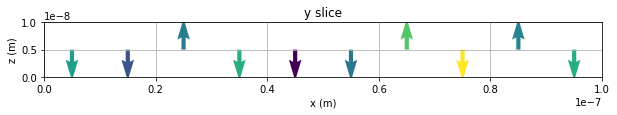

In [24]:
system.m.plot_slice("y", 0);

We see that the uniaxial anisotropy aligned the magnetisation so that it is on the anisotropy, but it did not have a prefererential direction. We can also check this by computing the average magnetisation.

In [25]:
system.m.average

(-2.4289212213845666, -1.4565154872401127, -3199999.9999984852)

We see that all three average magnetisation components are much less than $M_\text{s}$.

### Exchange energy

So far, Zeeman and uniaxial anisotropy energies were local. In other words, they did not take into account surrounding magnetisation. Exchange energy that we demonstrate now is not local and tends to align all magnetic moments in the same direction, but does not have a preferential direction. Its energy density is:

$$w_\text{ex} = A[(\nabla m_{x})^{2} + (\nabla m_{y})^{2} + (\nabla m_{z})^{2}],$$

where $A$ is the exchange energy constant. We will assume the exchange energy is $A = 8 \times 10^{-11} \,\text{J}\,\text{m}^{-1}$ and accordingly, the exchange energy object is:

In [26]:
A = 8e-11  # exchange energy constant (J/m)

exchange = oc.Exchange(A=A)

exchange

Exchange(A=8e-11)

By providing only this energy term to the system's Hamiltonian and running the time evolution, we get the following magnetisation configuration:

2017/3/16 12:18: Calling OOMMF (exchange_tutorial/exchange_tutorial.mif) ... [2.8s]


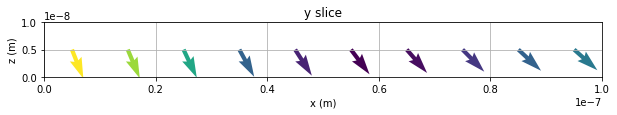

In [27]:
system = oc.System(name="exchange_tutorial")

system.hamiltonian = exchange
system.dynamics = dynamics
system.m = random_field

td = oc.TimeDriver()
td.drive(system, t=1.5e-9, n=100)

system.m.plot_slice("y", 0);

We can see that the magnetisation in now aligned at all discretisation cells.

### Dzyaloshinskii-Moriya

Exchange energy tends to align all magnetic moments parallel to each other. Opposite to that, Dzyaloshinkii-Moriya interaction (DMI) tends to align all neighbouring moments perpendicular to each other. Its energy density for bulk form of the DMI is:

$$w_\text{dmi} = D\mathbf{m}\cdot(\nabla \times \mathbf{m}),$$

where $D$ is the Dzyaloshinkii-Moriya energy constant. The DMI energy object is:

In [28]:
D = 5e-3  # Dzyaloshinkii-Moriya energy constant (J/m**2)

dmi = oc.DMI(D=D)
dmi

DMI(D=0.005)

Starting with a random magnetisation configuration, and evolving the system, we get:

2017/3/16 12:18: Calling OOMMF (dmi_tutorial/dmi_tutorial.mif) ... [2.7s]


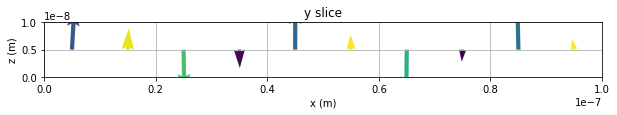

In [29]:
system = oc.System(name="dmi_tutorial")

system.hamiltonian = dmi
system.dynamics = dynamics
system.m = random_field

td = oc.TimeDriver()
td.drive(system, t=1.5e-9, n=100)

system.m.plot_slice("y", 0);

We can see that all neghbouring magnetic moments are perpendicular to each other.

### Demagnetisation

Can we invent some simple and easy to understand 1D example?

## Mutual competition of magnetic energies (find a new title)

So far, we simulated magnetic systems where only one magnetic energy was present. In this section, we will look into how the presence of multiple energy terms in the Hamiltonian affect the final relaxed magnetisation configuration.

### Exchange and Zeeman energies

This is probably the simplest combination of energy terms, present in all ferromagnetic materials. As we showed before, exchange energy tends to align all spins parallel to each other while the Zeeman energy wants them all in the direction of applied magnetic field. More precisely, although exchange energy does not have a preferential direction, external magnetic field would give the preferred direction (via Zeeman interaction).

Let us assume the external magnetic field to be $\mathbf{H} = (10^{6}, 0, 10^{6}) \,\text{a}\,\text{m}^{-1}$ Similar to the previous cases, if we start from the random magnetisation configuration, we get:

2017/3/16 12:18: Calling OOMMF (exchange_zeeman_tutorial/exchange_zeeman_tutorial.mif) ... [2.5s]


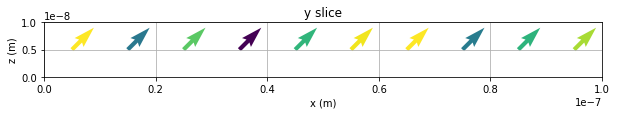

In [30]:
system = oc.System(name="exchange_zeeman_tutorial")

system.hamiltonian = oc.Exchange(A=1e-11) + oc.Zeeman(H=(1e6, 0, 1e6))
system.dynamics = dynamics
system.m = random_field

td = oc.TimeDriver()
td.drive(system, t=1e-9, n=100)

system.m.plot_slice("y", 0);

We can see that (as expected) all spins are parallel to each other and in the direction of external magnetic field $\mathbf{H}$.

### Exchange and Dzyaloshinkii-Moriya

Previously, when we explored the combination of exchange and Zeeman energies, the final magnetisation configuration was a minimun energy state for both of them. However, in the combination of exchange and DMI energies, none of the two energies can be individually minimum in the end. More precisely, exchange energy tends to align neighbouring magnetic moments parallel to each other. On the other hand, DMI wants them perpendicular to each other. Therefore, these two energies compete and end up with a compromise. Let us run an example:

2017/3/16 12:18: Calling OOMMF (exchange_dmi_tutorial/exchange_dmi_tutorial.mif) ... [2.5s]


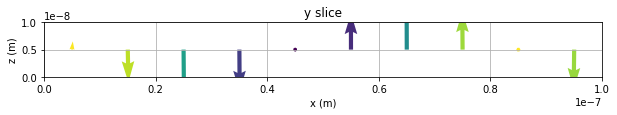

In [31]:
system = oc.System(name="exchange_dmi_tutorial")

system.hamiltonian = oc.Exchange(A=1e-11) + oc.DMI(D=2e-3)
system.dynamics = dynamics
system.m = random_field

td = oc.TimeDriver()
td.drive(system, t=5e-9, n=100)

system.m.plot_slice("y", 0);

We see that we ended up with a spiral configuration.

### Skyrmion

So far, all combinations of magnetic energies resulted in configurations that can be intuitivelly predicted. However, let us imagine a more complicated case in which we have all four magnetic energies in a two-dimensional sample.

2017/3/16 12:45: Calling OOMMF (dmi_tutorial/dmi_tutorial.mif) ... [27.7s]


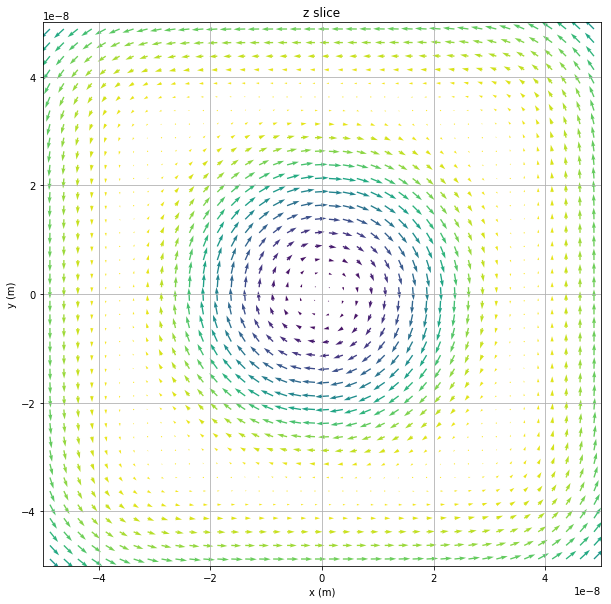

In [30]:
import numpy as np

mesh = oc.Mesh(p1=(-50e-9, -50e-9, 0), p2=(50e-9, 50e-9, 10e-9), cell=(2.5e-9, 2.5e-9, 10e-9))

def m_initial(pos):
    x, y, z = pos
    if np.sqrt(x**2 + y**2) < 20e-9:
        return (0, 0, -1)
    else:
        return (0, 0, 1)

system.hamiltonian = oc.Exchange(A=8.78e-12) + oc.DMI(D=1.58e-3) + oc.Zeeman(H=(0, 0, 1e5)) + \
                     oc.UniaxialAnisotropy(K=1e3, u=(0, 0, 1))
system.dynamics = oc.Precession(gamma=2.211e5) + oc.Damping(alpha=0.5)
system.m = df.Field(mesh, value=m_initial, norm=384e3)

td = oc.TimeDriver()
td.drive(system, t=5e-9, n=100)

system.m.plot_slice("z", 0);

The final configuration is the isolated skyrmion. We can plot its profile:

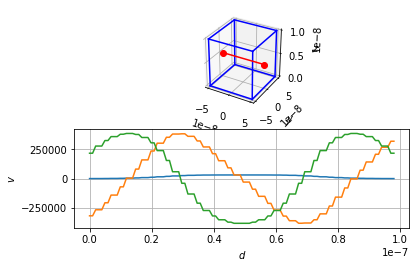

In [33]:
system.m.plot_line_intersection(p1=(-49e-9, 0, 5e-9), p2=(49e-9, 0, 5e-9))